# Homework 2

In this homework, we will go through the Hough transform, line detection with RANSAC, Harris corner detector, simple descriptpr and keypoint matching, and SIFT points.

## Notes on Running This Notebook

Make sure to run each Part from it's begining to ensure that you compute all of the dependencies of your current question and don't crossover variables with the same name from other questions. For example, don't run parts 4 and 5 and then return to run only the last cell of part 3; your panorama won't be using the right transformed images!  So long as you run each Part from it's beginning, you can run the Parts in any order.

When assembling your PDF, we recommend running all cells in order from the top of the notebook to prevent any of these discontinuity errors.

# Setup

### **Step 1**

First, run the cells below to clone the `CS131_release` [repo](https://github.com/StanfordVL/CS131_release) and `cd` into the correct directory in order to access some necessary files.

In [1]:
import os

if not os.path.exists("CS131_release"):
    # Clone the repository if it doesn't already exist
    !git clone https://github.com/StanfordVL/CS131_release.git

In [2]:
%cd CS131_release/winter_2025/hw2_release/

/content/CS131_release/winter_2025/hw2_release


### **Step 2**
Next, run the cells below to install the necessary libraries and packages.

In [3]:
# Install the necessary dependencies
# (restart your runtime session if prompted to, and then re-run this cell)

!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [4]:
# Imports the print function from newer versions of python
from __future__ import print_function

# Numpy is the main package for scientific computing with Python.
# This will be one of our most used libraries in this class
import numpy as np

# The Time library helps us time code runtimes
import time

# PIL (Pillow) is a useful library for opening, manipulating, and saving images
from PIL import Image

# skimage (Scikit-Image) is a library for image processing
from skimage import io
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread

from scipy.ndimage import convolve
from scipy.spatial.distance import cdist

import cv2 as cv

# Matplotlib is a useful plotting library for python
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


### I USED CHATGPT ABOVE SO I COULD UNDERSTAND WHAT THE IMPORTS DO

## Part 1: Lane Detection (15 points)

In this section we will implement a simple lane detection application using Canny edge detector and Hough transform.

The algorithm can broken down into the following steps:
1. Detect edges using the Canny edge detector.
2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).
3. Run Hough transform to detect lanes.

### 1.1 Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Our edge detection algorithm by itself should be able to find the lanes pretty well. Run the code cell below to load the example image and detect edges from the image.

Add your code from HW1 for the functions below.

In [6]:
def gaussian_kernel(size, sigma):
    """ Implementation of Gaussian Kernel.

    This function follows the gaussian kernel formula,
    and creates a kernel matrix.

    Hints:
    - Use np.pi and np.exp to compute pi and exp.

    Args:
        size: int of the size of output matrix.
        sigma: float of sigma to calculate kernel.

    Returns:
        kernel: numpy array of shape (size, size).
    """

    kernel = np.zeros(( size,size))
    ax = np.arange(size)- (size-1) / 2.0
    xx,yy = np.meshgrid(ax,ax)

    kernel = np.exp(-(xx** 2 + yy **2) / (2 * sigma ** 2))
    kernel /= 2 * np.pi * sigma ** 2
    kernel /= kernel.sum()

    return kernel

def conv(image, kernel):
    """ An implementation of convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).

    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # For this assignment, we will use edge values to pad the images.
    # Zero padding will make derivatives at the image boundary very big,
    # whereas we want to ignore the edges at the boundary.
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    kernel_flipped = np.flipud(np.fliplr(kernel))

    # Slide the window
    for i in range(Hi):
        for j in range(Wi):
            patch = padded[i:i + Hk, j:j + Wk]     # (H_k, W_k)
            out[i, j] = np.sum(patch * kernel_flipped)

    return out

def partial_x(img):
    """ Computes partial x-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: x-derivative image.
    """

    out = None
    kx = np.array([[0.5, 0, -0.5]], dtype=np.float32)
    out = conv(img.astype(np.float32),kx)
    return out

def partial_y(img):
    """ Computes partial y-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: y-derivative image.
    """

    out = None
    ky = np.array([[ 0.5],[ 0.0],[-0.5]], dtype=np.float32)
    out = conv(img.astype(np.float32), ky )
    return out

def gradient(img):
    """ Returns gradient magnitude and direction of input img.

    Args:
        img: Grayscale image. Numpy array of shape (H, W).

    Returns:
        G: Magnitude of gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of gradient
            at each pixel in img. Numpy array of shape (H, W).

    Hints:
        - Use np.sqrt and np.arctan2 to calculate square root and arctan
    """
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    dx = partial_x(img.astype(np.float32))
    dy = partial_y(img.astype(np.float32))

    G = np.sqrt(dx ** 2 + dy ** 2, dtype = np.float32)
    theta = (np.degrees(np.arctan2(dy, dx))+360) %360
    return G, theta

def non_maximum_suppression(G, theta):
    """ Performs non-maximum suppression.

    This function performs non-maximum suppression along the direction
    of gradient (theta) on the gradient magnitude image (G).

    Args:
        G: gradient magnitude image with shape of (H, W).
        theta: direction of gradients with shape of (H, W).

    Returns:
        out: non-maxima suppressed image.
    """
    H, W = G.shape
    out = np.zeros((H, W))

    theta = np.floor((theta + 22.5) / 45) * 45
    theta = (theta %360.0).astype(np.int32)

    for i in range(1, H - 1):
        for j in range(1, W-1):
            angle = theta[i, j]
            mag=G[i, j]

            if angle == 0 or angle == 180:
                neigh1, neigh2 = G[i, j - 1], G[i, j + 1]
            elif angle == 45 or angle == 225:
                neigh1, neigh2 = G[i - 1, j + 1], G[i + 1, j - 1]
            elif angle == 90 or angle == 270:
                neigh1, neigh2 = G[i - 1, j], G[i + 1, j]
            elif angle == 135 or angle == 315:
                neigh1, neigh2 = G[i - 1, j - 1], G[i + 1, j + 1]
            else:
                neigh1 = neigh2 = 0

            if mag >= neigh1 and mag >= neigh2:
                out[i, j] = mag
    return out

def double_thresholding(img, high, low):
    """
    Args:
        img: numpy array of shape (H, W) representing NMS edge response.
        high: high threshold(float) for strong edges.
        low: low threshold(float) for weak edges.

    Returns:
        strong_edges: Boolean array representing strong edges.
            Strong edeges are the pixels with the values greater than
            the higher threshold.
        weak_edges: Boolean array representing weak edges.
            Weak edges are the pixels with the values smaller or equal to the
            higher threshold and greater than the lower threshold.
    """

    strong_edges = np.zeros(img.shape, dtype=bool)
    weak_edges = np.zeros(img.shape, dtype=bool)

    ### YOUR CODE HERE

    ### END YOUR CODE

    return strong_edges, weak_edges

def link_edges(strong_edges, weak_edges):
    """ Find weak edges connected to strong edges and link them.

    Iterate over each pixel in strong_edges and perform breadth first
    search across the connected pixels in weak_edges to link them.
    Here we consider a pixel (a, b) is connected to a pixel (c, d)
    if (a, b) is one of the eight neighboring pixels of (c, d).

    Args:
        strong_edges: binary image of shape (H, W).
        weak_edges: binary image of shape (H, W).

    Returns:
        edges: numpy boolean array of shape(H, W).
    """

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=bool)

    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    nbrs = [(-1, -1), (-1, 0), (-1, 1),
            ( 0, -1),          ( 0, 1),
            ( 1, -1), ( 1, 0), ( 1, 1)]

    # Use a list as a FIFO queue for BFS
    from collections import deque
    q = deque(map(tuple, indices))          # initialise with all strong-edge coords

    while q:
        y, x = q.popleft()

        # Explore 8 neighbours
        for dy, dx in nbrs:
            ny, nx = y + dy, x + dx
            if 0 <= ny < H and 0 <= nx < W and weak_edges[ny, nx]:
                weak_edges[ny, nx] = False
                edges[ny, nx] = True
                q.append((ny, nx))

    return edges

def get_neighbors(y, x, H, W):
    """ Return indices of valid neighbors of (y, x).

    Return indices of all the valid neighbors of (y, x) in an array of
    shape (H, W). An index (i, j) of a valid neighbor should satisfy
    the following:
        1. i >= 0 and i < H
        2. j >= 0 and j < W
        3. (i, j) != (y, x)

    Args:
        y, x: location of the pixel.
        H, W: size of the image.
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)].
    """
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i==y and j==x):
                    continue
                neighbors.append((i, j))

    return neighbors

In [7]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
    """ Implement canny edge detector by calling functions above.

    Args:
        img: binary image of shape (H, W).
        kernel_size: int of size for kernel matrix.
        sigma: float for calculating kernel.
        high: high threshold for strong edges.
        low: low threashold for weak edges.
    Returnsa:
        edge: numpy array of shape(H, W).
    """
    g_kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = conv(img.astype(np.float32), g_kernel)
    G, theta = gradient(smoothed)
    nms = non_maximum_suppression(G, theta)
    strong_edges = nms >= high
    weak_edges   = (nms >= low) & (nms < high)

    return link_edges(strong_edges, weak_edges)

In [8]:
# Load image
img = io.imread('road.jpg', as_gray=True)

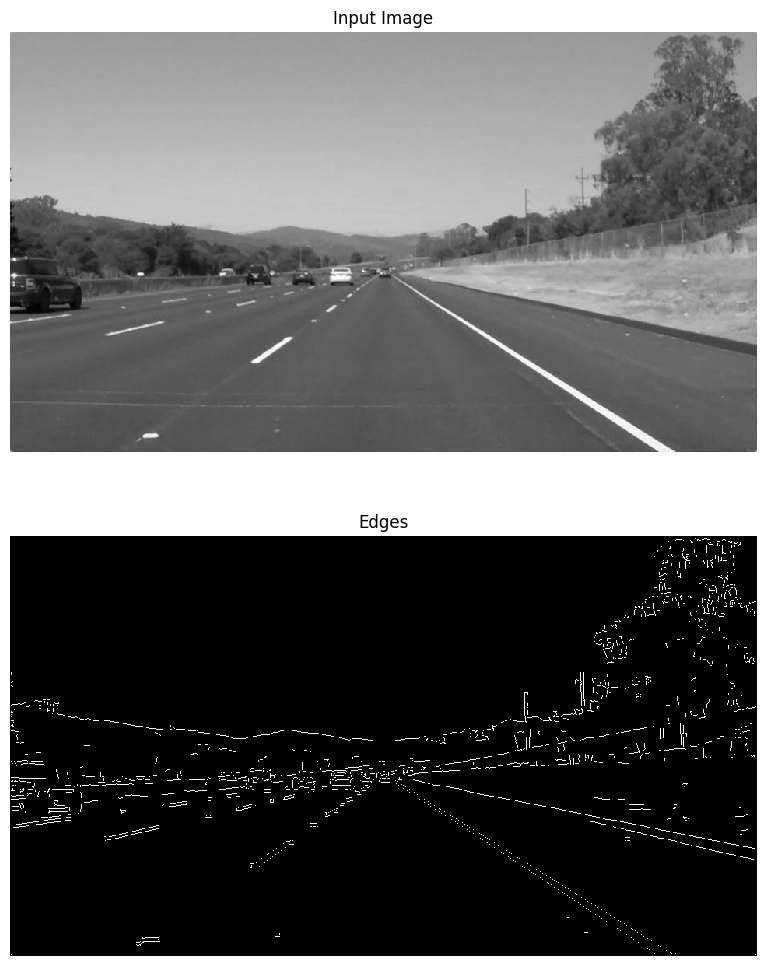

In [9]:
# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

### 1.2 Extracting region of interest (ROI)
We can see that the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extract the edges within the region.

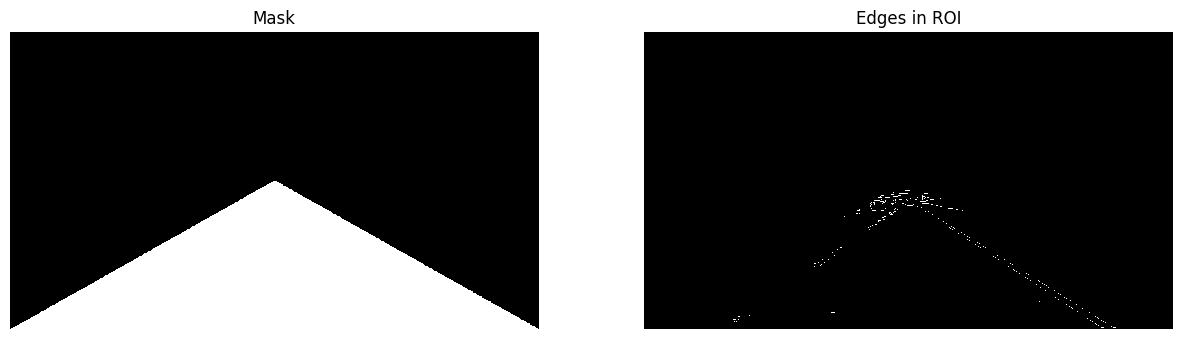

In [10]:
H, W = img.shape
##MASK
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

### 1.3 Fitting lines using Hough transform (15 points)
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. This is the parameterization we often use when introducing the Hough transform.  However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map every point in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.


In [11]:
def hough_transform(img):
    """ Transform points in the input image into Hough space.

    Use the parameterization:
        rho = x * cos(theta) + y * sin(theta)
    to transform a point (x,y) to a sine-like function in Hough space.

    Args:
        img: binary image of shape (H, W).

    Returns:
        accumulator: numpy array of shape (m, n).
        rhos: numpy array of shape (m, ).
        thetas: numpy array of shape (n, ).
    """
    # Set rho and theta ranges
    W, H = img.shape
    diag_len = int(np.ceil(np.sqrt(W * W + H * H)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2 + 1)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    # Cache some reusable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Initialize accumulator in the Hough space
    accumulator = np.zeros((2 * diag_len + 1, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(img)

    # Transform each point (x, y) in image
    # Find rho corresponding to values in thetas
    # and increment the accumulator in the corresponding coordiate.
    ### YOUR CODE HERE


    for (y, x) in zip(ys, xs):
        rho_vals = x * cos_t + y * sin_t
        rho_idxs = np.round(rho_vals + diag_len).astype(int)
        accumulator[rho_idxs,  np.arange(num_thetas )] += 1

    ### END YOUR CODE

    return accumulator, rhos, thetas

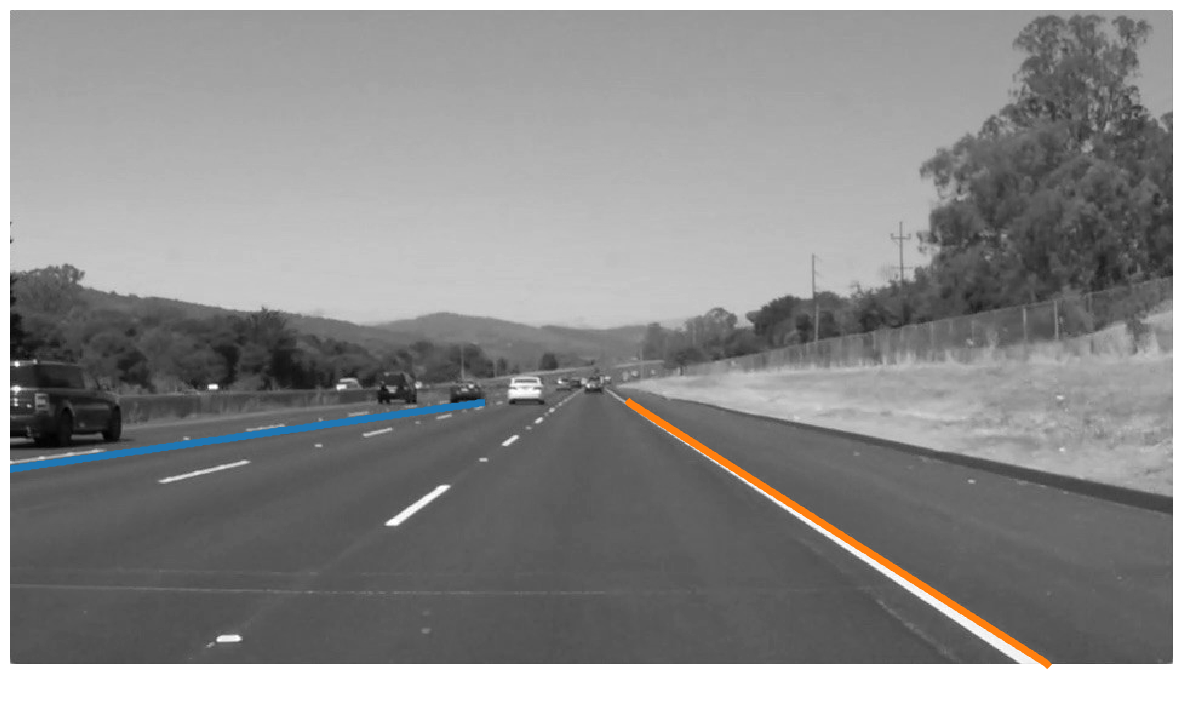

In [12]:
# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]

    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break

    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()

## Part 2

## 2.1 Harris Corner Detector (20 points)


In this section, you are going to implement Harris corner detector for keypoint localization. Review the lecture slides on Harris corner detector to understand how it works. The Harris detection algorithm can be divide into the following steps:
1. Compute $x$ and $y$ derivatives ($I_x, I_y$) of an image
2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel
3. Compute matrix $M$ at each pixel, where
$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel
5. Output corner response map $R(x,y)$

Step 1 is already done for you in the function **`harris_corners`**. We used the [Sobel Operator](https://en.wikipedia.org/wiki/Sobel_operator), which computes smoothed gradients at each pixel in the x and y direction. See skimage documentation for [sobel_v](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel_v) and [sobel_h](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel_h) for more information on the sobel kernels and operators.

For step 3, we've created a uniform window function w for you in the starter code. You can assume that the window size will be odd.

Complete the function implementation of **`harris_corners`** and run the code below.

### Hint: There are two ways to solve this problem

**Vectorized**: If you want to be really efficient, you can use the function `scipy.ndimage.convolve`, and compute the response map R at every pixel all at once. If you're clever with your convolutions and determinant and trace calculations, you can compute the windowed gradients in $M$ ($\sum_{x,y} w(x,y) \cdot I_x^2$, and $\sum_{x,y} w(x,y) \cdot I_y^2$, and $\sum_{x,y} w(x,y) \cdot I_{xy}$), and then compute the response map without any for loops!

**Iterative**: The more intuitive solution is to iterate through each pixel of the image, compute $M$ based on the surrounding neighborhood of pixel gradients in $I_x$, $I_y$, and $I_{xy}$, and then compute the response map pixel $R(x,y)$. You may find your implementations of conv_nested and conv_fast from HW 1 to be useful references!

Note that you'll want to explictly specify zero-padding to match the Harris response map definition, but we'll accept the default behavior of `scipy.ndimage.convolve` as well. If you use zero-padding, both the vectorized and for-loop implementations will get you to the same answer!

The 'Alternate Accepted Harris Corner Solution' image presents the result of `scipy.ndimage.convolve`'s default reflection padding, while the 'Harris Corner Solution' image presents the zero-padding solution. Similarly, 'Alternate Accepted Detected Corners Solution' image presents the result of `scipy.ndimage.convolve`'s default reflection padding, while the 'Detected Corners Solution' image presents the zero-padding solution. **Both are accepted solutions!**


In [13]:
def harris_corners(img, window_size=3, k=0.04):
    """
    Compute Harris corner response map. Follow the math equation
    R=Det(M)-k(Trace(M)^2).

    Hint:
        You may use the function scipy.ndimage.filters.convolve,
        which is already imported above. If you use convolve(), remember to
        specify zero-padding to match our equations, for example:

            out_image = convolve(in_image, kernel, mode='constant', cval=0)

        You can also use for nested loops compute M and the subsequent Harris
        corner response for each output pixel, intead of using convolve().
        Your implementation of conv_fast or conv_nested in HW1 may be a
        useful reference!

    Args:
        img: Grayscale image of shape (H, W)
        window_size: size of the window function
        k: sensitivity parameter

    Returns:
        response: Harris response image of shape (H, W)
    """

    H, W = img.shape
    window = np.ones((window_size, window_size))

    response = np.zeros((H, W))

    # 1. Compute x and y derivatives (I_x, I_y) of an image
    dx = filters.sobel_v(img)
    dy = filters.sobel_h(img)
    ### YOUR CODE HERE
    Ixx = dx * dx
    Iyy = dy * dy
    Ixy = dx * dy
#SUM
    Sxx = filters.convolve(Ixx, window, mode='constant', cval=0.0)
    Syy = filters.convolve(Iyy, window, mode='constant', cval=0.0)
    Sxy = filters.convolve(Ixy, window, mode='constant', cval=0.0)

    det_M   = Sxx *Syy -Sxy **2
    trace_M= Sxx + Syy
    response =det_M - k * (trace_M** 2)
    ### END YOUR CODE


    return response

In [14]:
def harris_corners_alternate_solutions(img, window_size=3, k=0.04):
    """
    Compute Harris corner response map. Follow the math equation
    R=Det(M)-k(Trace(M)^2).

    Hint:
        You may use the function scipy.ndimage.filters.convolve,
        which is already imported above. If you use convolve(), remember to
        specify zero-padding to match our equations, for example:

            out_image = convolve(in_image, kernel, mode='constant', cval=0)

        You can also use for nested loops compute M and the subsequent Harris
        corner response for each output pixel, intead of using convolve().
        Your implementation of conv_fast or conv_nested in HW1 may be a
        useful reference!

    Args:
        img: Grayscale image of shape (H, W)
        window_size: size of the window function
        k: sensitivity parameter

    Returns:
        response: Harris response image of shape (H, W)
    """

    H, W = img.shape
    window = np.ones((window_size, window_size))

    response_forloop = np.zeros((H, W))
    response_convolve_default = np.zeros((H, W))
    dx = filters.sobel_v(img)
    dy = filters.sobel_h(img)
    Ixx = dx * dx
    Iyy = dy * dy
    Ixy = dx * dy

    Sxx = filters.convolve(Ixx, window, mode='constant', cval=0)
    Syy = filters.convolve(Iyy, window, mode='constant', cval=0)
    Sxy = filters.convolve(Ixy, window, mode='constant', cval=0)

    det_M   = Sxx *Syy - Sxy ** 2
    trace_M = Sxx + Syy

    response = det_M-k *(trace_M ** 2)


    return response_convolve_default, response_forloop

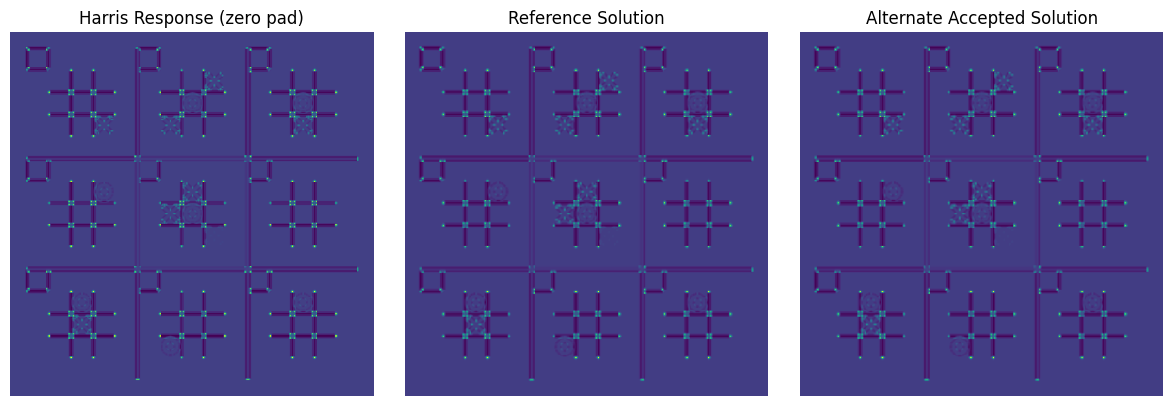

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio          # v2 API keeps the old behaviour -- usedGPT for this
from skimage import filters            # sobel_v / sobel_h
import scipy.ndimage as ndimage

def imread(path, as_gray=False):
    if as_gray:
        return imageio.imread(path, mode="F")
    return imageio.imread(path)

def harris_corners(img, window_size=3, k=0.04):
    """
    Compute the Harris corner response map for a grayscale image.
    """
    window = np.ones((window_size, window_size))

    dx = filters.sobel_v(img)
    dy = filters.sobel_h(img)

    Ixx, Iyy, Ixy = dx * dx, dy * dy, dx * dy

    Sxx = ndimage.convolve(Ixx, window, mode="constant", cval=0.0)
    Syy = ndimage.convolve(Iyy, window, mode="constant", cval=0.0)
    Sxy = ndimage.convolve(Ixy, window, mode="constant", cval=0.0)

    det   = Sxx * Syy - Sxy ** 2
    trace = Sxx + Syy
    response = det - k * trace ** 2
    return response

# ---------------------------------------------------------------------

img = imread("tictactoe.png", as_gray=True)

response = harris_corners(img)
window_size = 3
k           = 0.04
window      = np.ones((window_size, window_size))

dx, dy      = filters.sobel_v(img), filters.sobel_h(img)
Ixx, Iyy, Ixy = dx*dx, dy*dy, dx*dy

# Variant 1: ndimage.convolve with *reflect* padding
Sxx_r = ndimage.convolve(Ixx, window, mode="reflect")
Syy_r = ndimage.convolve(Iyy, window, mode="reflect")
Sxy_r = ndimage.convolve(Ixy, window, mode="reflect")
det_r   = Sxx_r * Syy_r - Sxy_r**2
trace_r = Sxx_r + Syy_r
response_convolve_default = det_r - k * trace_r**2

# Variant 2: explicit for-loop with ZERO padding
pad            = window_size // 2
Ixx_p          = np.pad(Ixx, pad, mode="constant")
Iyy_p          = np.pad(Iyy, pad, mode="constant")
Ixy_p          = np.pad(Ixy, pad, mode="constant")
H, W           = img.shape
response_forloop = np.zeros_like(img, dtype=np.float32)

for y in range(H):
    for x in range(W):
        win_Ixx = Ixx_p[y:y+window_size, x:x+window_size].sum()
        win_Iyy = Iyy_p[y:y+window_size, x:x+window_size].sum()
        win_Ixy = Ixy_p[y:y+window_size, x:x+window_size].sum()
        det     = win_Ixx * win_Iyy - win_Ixy**2
        trace   = win_Ixx + win_Iyy
        response_forloop[y, x] = det - k * trace**2
# ---------------------------------------------------------------------

# Display results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(response, cmap="viridis")
plt.axis("off")
plt.title("Harris Response (zero pad)")

plt.subplot(1, 3, 2)
plt.imshow(imread("tictactoe_solution_harris.png", as_gray=True), cmap="viridis")
plt.axis("off")
plt.title("Reference Solution")

plt.subplot(1, 3, 3)
plt.imshow(imread("tictactoe_alternate_solution_harris.png", as_gray=True), cmap="viridis")
plt.axis("off")
plt.title("Alternate Accepted Solution")

plt.tight_layout()
plt.show()
#USED GPT TO EXPLAIN RESULTS

Once you implement the Harris detector correctly, you will be able to see small bright blobs around the corners of the tic tac toe grids and shapes in the output corner response image. The function `corner_peaks` from `skimage.feature` performs non-maximum suppression to take local maxima of the response map and localize keypoints.

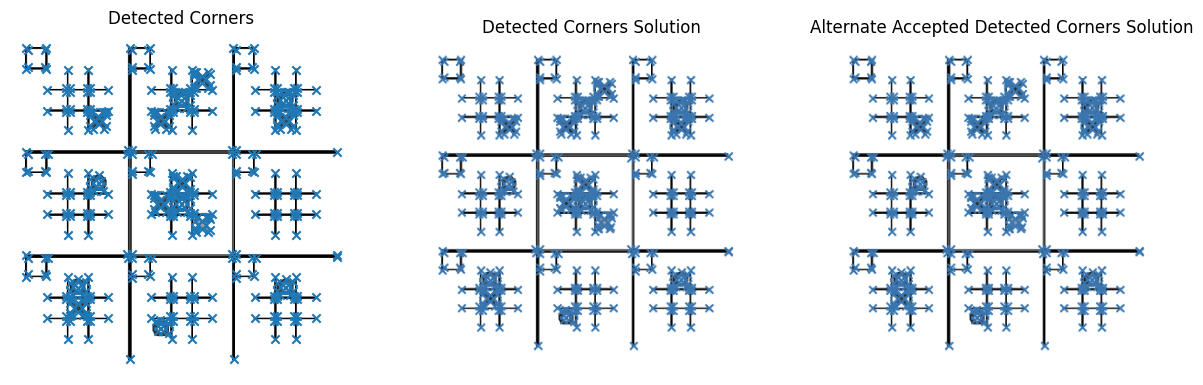

In [16]:
# Perform non-maximum suppression in response map
# and output corner coordinates
corners = corner_peaks(response, threshold_rel=0.01)

corners_convolve_default = corner_peaks(response_convolve_default, threshold_rel=0.01)
corners_forloop = corner_peaks(response_forloop, threshold_rel=0.01)

# Display detected corners
plt.subplot(1,3,1)
plt.imshow(img)
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')

plt.subplot(1,3,2)
plt.imshow(imread('tictactoe_solution_detected_corners.png'))
plt.axis('off')
plt.title('Detected Corners Solution')

plt.subplot(1,3,3)
plt.imshow(imread('tictactoe_alternate_solution_detected_corners.png'))
plt.axis('off')
plt.title('Alternate Accepted Detected Corners Solution')

plt.show()

## Part 3 Describing and Matching Keypoints (20 points)

We are now able to localize keypoints in two images by running the Harris corner detector independently on them. Next question is, how do we determine which pair of keypoints come from corresponding locations in those two images? In order to *match* the detected keypoints, we must come up with a way to *describe* the keypoints based on their local appearance. Generally, each region around detected keypoint locations is converted into  a fixed-size vectors called *descriptors*.

### Part 3.1 Creating Descriptors (10 points)

In this section, you are going to implement the **`simple_descriptor`** function, where each keypoint is described by the normalized intensity of a small patch around it.


In [17]:
def simple_descriptor(patch):
    """
    Describe the patch by normalizing the image values into a standard
    normal distribution (having mean of 0 and standard deviation of 1)
    and then flattening into a 1D array.

    The normalization will make the descriptor more robust to change
    in lighting condition.
`
    Hint:
        In this case of normalization, if a denominator is zero, divide by 1 instead.

    Args:
        patch: grayscale image patch of shape (H, W)

    Returns:
        feature: 1D array of shape (H * W)
    """
    feature = []
    patch = patch.astype(np.float32)

    mu= patch.mean()
    sigma = patch.std()
    if sigma == 0:
        sigma = 1.0

    normalized = (patch - mu) / sigma
    feature    = normalized.flatten()

    return feature

Keypoints 1 shape =  (25796, 2)
Keypoints 2 shape =  (20617, 2)


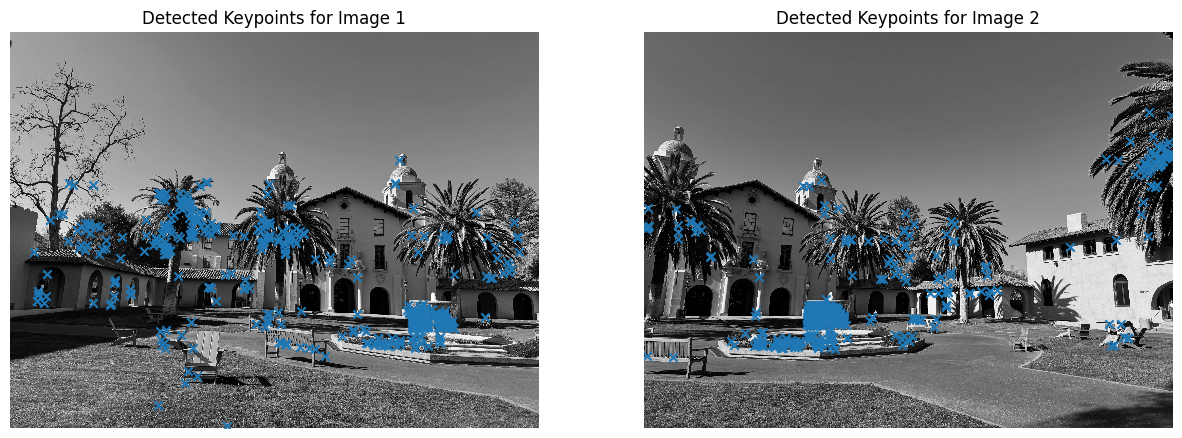

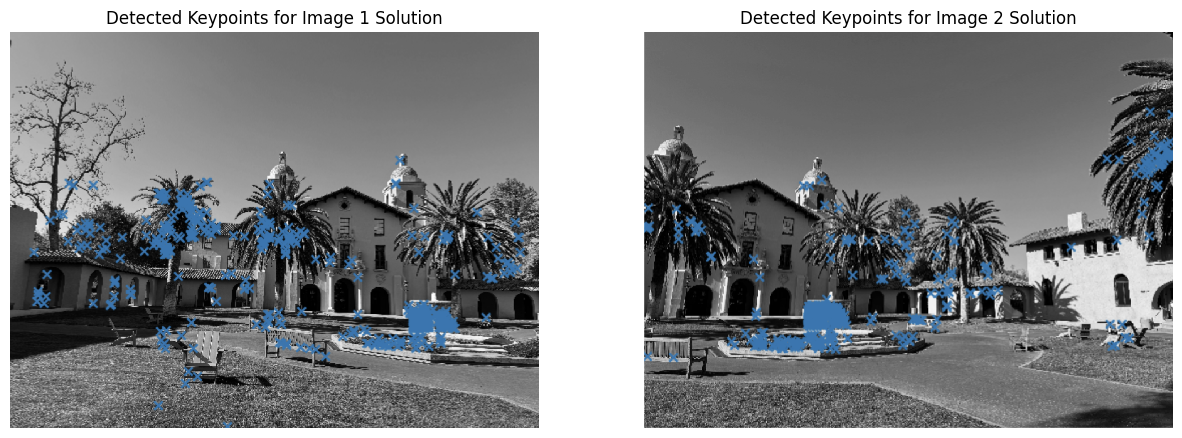

In [18]:
img1 = imread('oldunion1.png', as_gray=True)
img2 = imread('oldunion2.png', as_gray=True)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

print("Keypoints 1 shape = ", keypoints1.shape)
print("Keypoints 2 shape = ", keypoints2.shape)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:500,1], keypoints1[:500,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:500,1], keypoints2[:500,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

# Display detected keypoints solution
plt.subplot(1,2,1)
plt.imshow(imread('oldunion_solution_kp1.png'))
plt.axis('off')
plt.title('Detected Keypoints for Image 1 Solution')

plt.subplot(1,2,2)
plt.imshow(imread('oldunion_solution_kp2.png'))
plt.axis('off')
plt.title('Detected Keypoints for Image 2 Solution')
plt.show()

### Part 3.2 Matching Descriptors (10 points)
Next, implement the **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: for each descriptor in image 1, if the distance to the closest descriptor in image 2 is significantly (by a given factor) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.

*Checking your answer*: you should see an identical matching of keypoints as the solution, but the precise colors of each line will change with every run of keypoint matching so colors do not need to match.

*Optional ungraded food for thought*: Think about why this method of keypoint matching is not commutative.

In [19]:
def describe_keypoints(image, keypoints, desc_func, patch_size=16):
    """
    Args:
        image: grayscale image of shape (H, W)
        keypoints: 2D array containing a keypoint (y, x) in each row
        desc_func: function that takes in an image patch and outputs
            a 1D feature vector describing the patch
        patch_size: size of a square patch at each keypoint

    Returns:
        desc: array of features describing the keypoints
    """

    image.astype( np.float32)
    desc = []

    for i, kp in enumerate(keypoints):
        y, x = kp
        patch = image[y-(patch_size//2 ):y+(( patch_size+1)//2),
                      x-(patch_size//2):x+(( patch_size+ 1)//2)]
        desc.append(desc_func( patch))
    return np.array(desc )

In [20]:
def match_descriptors(desc1, desc2, threshold=0.5):
    """
    Match the feature descriptors by finding distances between them. A match is formed
    when the distance to the closest vector is much smaller than the distance to the
    second-closest, that is, the ratio of the distances should be STRICTLY SMALLER
    than the threshold (NOT equal to). Return the matches as pairs of vector indices.

    Hint:
        The Numpy functions np.sort, np.argmin, np.asarray might be useful

        The Scipy function cdist calculates Euclidean distance between all
        pairs of inputs
    Args:
        desc1: an array of shape (M, P) holding descriptors of size P about M keypoints
        desc2: an array of shape (N, P) holding descriptors of size P about N keypoints

    Returns:
        matches: an array of shape (Q, 2) where each row holds the indices of one pair
        of matching descriptors
    """
    matches = []

    M = desc1.shape[0]
    dists = cdist(desc1, desc2)

    sorted_idx = np.argsort(dists, axis=1)
    nn1_idx = sorted_idx[:, 0]
    nn2_idx = sorted_idx[:, 1]

    nn1_dist= dists[np.arange(desc1.shape[0]), nn1_idx]
    nn2_dist= dists[np.arange(desc1.shape[0]), nn2_idx]

    good_mask= nn1_dist /nn2_dist < threshold

    matches = np.stack([np.arange(desc1.shape[0])[good_mask],
                        nn1_idx[good_mask]], axis=1)

    return matches

In [21]:
def plot_matches(ax, image1, image2, keypoints1, keypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=False):
    """Plot matched features.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matches and image are drawn in this ax.
    image1 : (N, M [, 3]) array
        First grayscale or color image.
    image2 : (N, M [, 3]) array
        Second grayscale or color image.
    keypoints1 : (K1, 2) array
        First keypoint coordinates as ``(row, col)``.
    keypoints2 : (K2, 2) array
        Second keypoint coordinates as ``(row, col)``.
    matches : (Q, 2) array
        Indices of corresponding matches in first and second set of
        descriptors, where ``matches[:, 0]`` denote the indices in the first
        and ``matches[:, 1]`` the indices in the second set of descriptors.
    keypoints_color : matplotlib color, optional
        Color for keypoint locations.
    matches_color : matplotlib color, optional
        Color for lines which connect keypoint matches. By default the
        color is chosen randomly.
    only_matches : bool, optional
        Whether to only plot matches and not plot the keypoint locations.
    """

    image1.astype(np.float32)
    image2.astype(np.float32)

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[:image2.shape[0], :image2.shape[1]] = image2
        image2 = new_image2

    image = np.concatenate([image1, image2], axis=1)

    offset = image1.shape

    if not only_matches:
        ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                   facecolors='none', edgecolors=keypoints_color)
        ax.scatter(keypoints2[:, 1] + offset[1], keypoints2[:, 0],
                   facecolors='none', edgecolors=keypoints_color)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, 2 * offset[1], offset[0], 0))

    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0]),
'-', color=color)

Desc1 shape =  (25796, 25)
Desc2 shape =  (20617, 25)


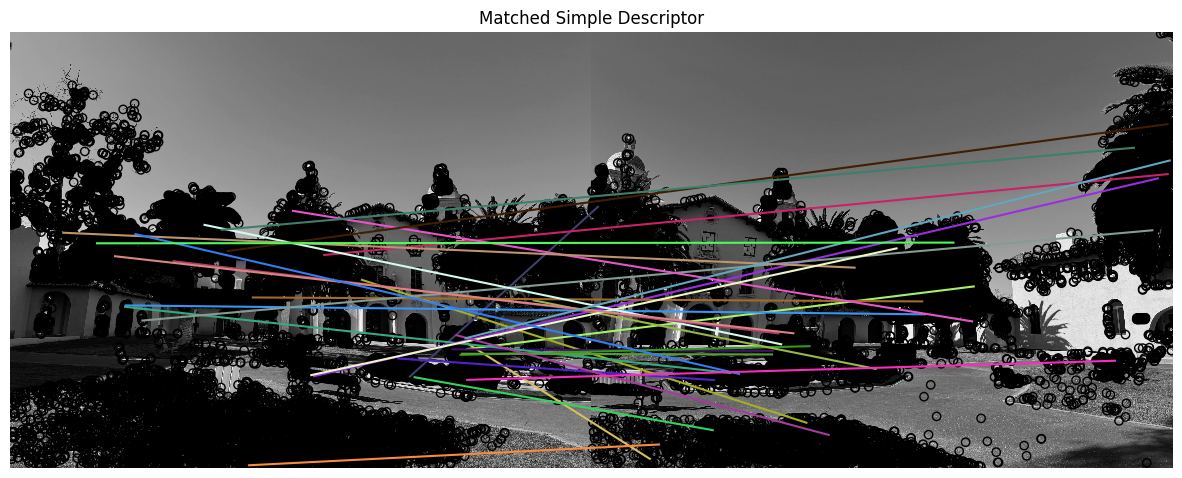

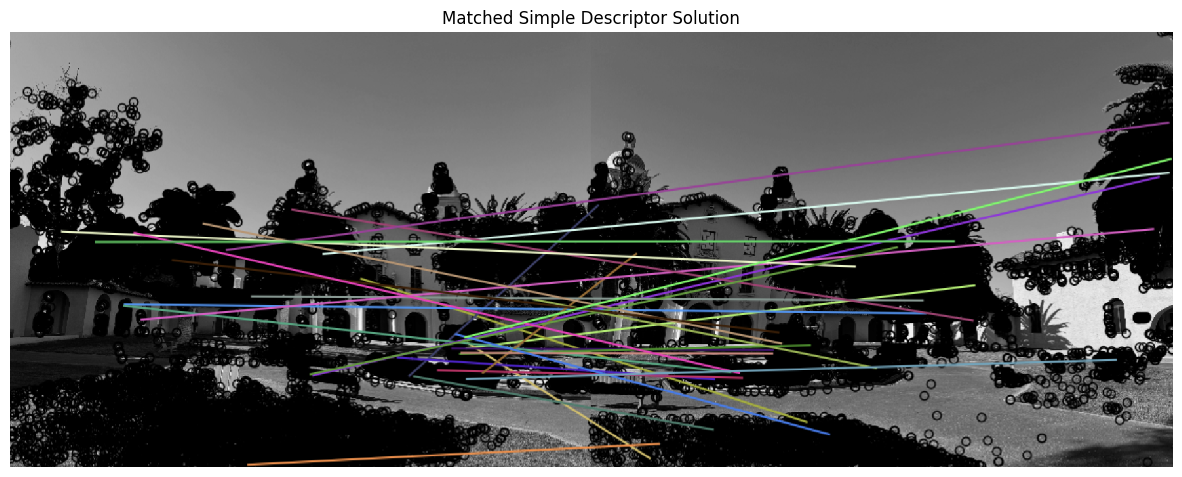

In [22]:
# Set seed to compare output against solution
np.random.seed(131)

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

print("Desc1 shape = ", desc1.shape)
print("Desc2 shape = ", desc2.shape)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1[:10000,:], desc2[:10000,:], 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plt.title('Matched Simple Descriptor')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches[:30,:])
plt.show()

plt.imshow(imread('oldunion_solution_simple_descriptor.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor Solution')
plt.show()

## Part 4 Describing and Matching Keypoints with SIFT (10 points)

In 2004, D.Lowe, University of British Columbia, came up with a new algorithm, Scale Invariant Feature Transform (SIFT) in his paper, Distinctive Image Features from Scale-Invariant Keypoints, which extract keypoints and compute its descriptors. We are now going to determine the keypoints of an image using Open CV functions.

### Part 4.1 Creating Descriptors (10 points)

In this section, you are going to implement an Open CV sift function to find the keypoints and descriptors. Then you are going to map the keypoints.

In [23]:
# Loading the image
img1 = cv.imread('oldunion1.png')
img2 = cv.imread('oldunion2.png')

 # Converting image to grayscale
img1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

### YOUR CODE HERE

sift = cv.SIFT_create()
kp1, descriptors1 = sift.detectAndCompute(img1, None)
kp2, descriptors2 = sift.detectAndCompute(img2, None)

### END YOUR CODE


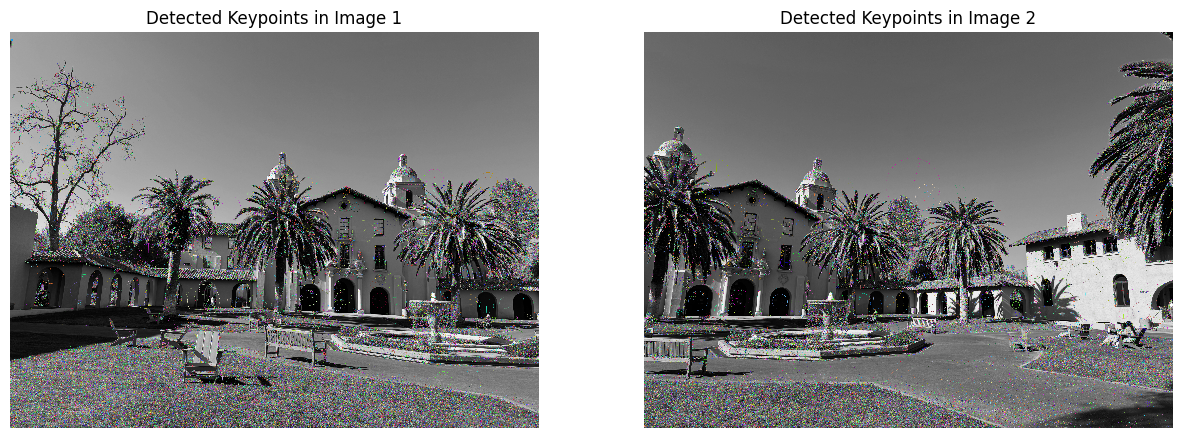

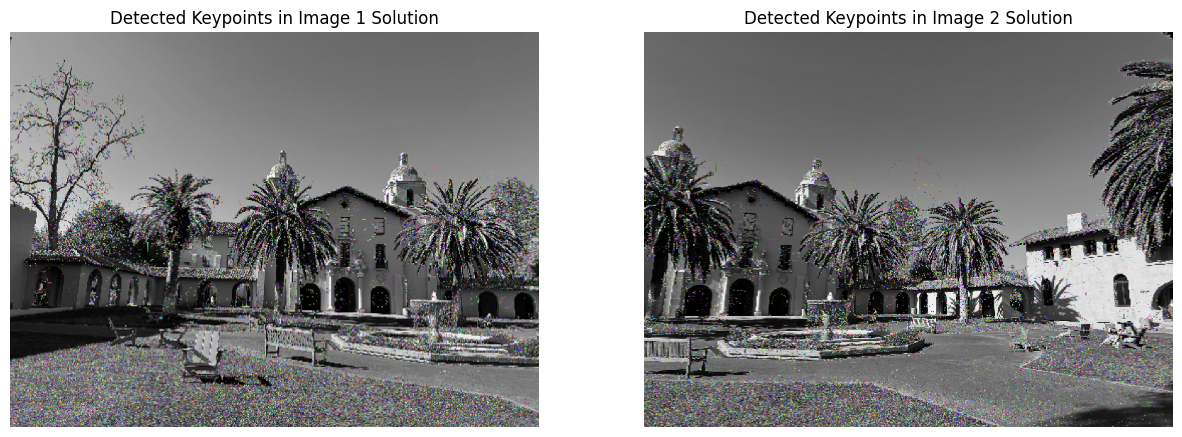

In [24]:
# Marking the keypoint on the image using circles
img1=cv.drawKeypoints(img1, kp1, img1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2=cv.drawKeypoints(img2, kp2, img2, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off')
plt.title('Detected Keypoints in Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.axis('off')
plt.title('Detected Keypoints in Image 2')
plt.show()

# Display detected keypoints solution
plt.subplot(1,2,1)
plt.imshow(imread('solution_detected_kp1.png'))
plt.axis('off')
plt.title('Detected Keypoints in Image 1 Solution')

plt.subplot(1,2,2)
plt.imshow(imread('solution_detected_kp2.png'))
plt.axis('off')
plt.title('Detected Keypoints in Image 2 Solution')
plt.show()


### Part 4.2 Matching Descriptors with SIFT (10 points)
Next, match the descriptors with the BFMatcher() function.

*Checking your answer*: the lines are hard to see, but your solution should be similar to our solution

In [ ]:
### YOUR CODE HERE
desc1_f32 = descriptors1.astype(np.float32)
desc2_f32 = descriptors2.astype(np.float32)
bf = cv.BFMatcher(cv.NORM_L2,  crossCheck=False)
knn_matches = bf.knnMatch(desc1_f32, desc2_f32, k=2)
ratio_thresh = 0.75
good_matches = [
    m for (m, n) in knn_matches
    if m.distance < ratio_thresh * n.distance]

print(f"{len(good_matches)} matches")
### END YOUR CODE

In [ ]:
img3 = cv.drawMatches(img1,kps1,img2,kps2,matches[:100],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)